In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick

bucket_name = "cs611_mle"

## Connect to GCP

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    project_id = "sound-memory-457612-b8"
    os.environ['GOOGLE_CLOUD_PROJECT'] = project_id
except:
    pass

## Bronze Layer

To determine whether a user churns in a certain membership plan or not, only the transactions dataset will be used. Therefore, in the label engineering part, only transactions.csv will be processed to follow the medallion architecture. Other tables will be processed in the feature engineering part.

In [5]:
### Ingesting data from Google Cloud Storage
transactions_file_path = "Data Source/transactions_50k.csv"
transactions_gcs_path = f"gs://{bucket_name}/{transactions_file_path}"

df_transactions = pd.read_csv(transactions_gcs_path)

In [29]:
print(f"transactions.shape: {df_transactions.shape}")

transactions.shape: (567004, 11)


In [30]:
print("---------------transactions.information---------------")
print(df_transactions.info())

---------------transactions.information---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567004 entries, 0 to 567003
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Unnamed: 0.1            567004 non-null  int64 
 1   Unnamed: 0              567004 non-null  int64 
 2   msno                    567004 non-null  object
 3   payment_method_id       567004 non-null  int64 
 4   payment_plan_days       567004 non-null  int64 
 5   plan_list_price         567004 non-null  int64 
 6   actual_amount_paid      567004 non-null  int64 
 7   is_auto_renew           567004 non-null  int64 
 8   transaction_date        567004 non-null  int64 
 9   membership_expire_date  567004 non-null  int64 
 10  is_cancel               567004 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 47.6+ MB
None


In [31]:
# Create bronze tables and store to Google Cloud Storage
bronze_transactions_file_path = "Bronze Layer/bronze_transactions.csv"
bronze_transactions_gcs_path = f"gs://{bucket_name}/{bronze_transactions_file_path}"

try:
    df_transactions.to_csv(bronze_transactions_gcs_path, index=False)
    print("bronze_transactions.csv Stored to Bronze Layer Successfully! ✅")
except Exception as e:
    print(f"bronze_transactions.csv Store Failed: {e}")

bronze_transactions.csv Stored to Bronze Layer Successfully! ✅


## Silver Layer

In [28]:
### Ingesting data from Google Cloud Storage
bronze_transactions_file_path = "Bronze Layer/bronze_transactions.csv"
bronze_transactions_gcs_path = f"gs://{bucket_name}/{bronze_transactions_file_path}"

df_transactions = pd.read_csv(bronze_transactions_gcs_path)

In [32]:
df_transactions = df_transactions.drop(columns=['Unnamed: 0'])
df_transactions['transaction_date'] = pd.to_datetime(df_transactions['transaction_date'], format='%Y%m%d')
df_transactions['membership_expire_date'] = pd.to_datetime(df_transactions['membership_expire_date'], format='%Y%m%d')
df_transactions['membership_start_date'] = (
    df_transactions['membership_expire_date'] -
    pd.to_timedelta(df_transactions['payment_plan_days'], unit='D')
)
# df_transactions = df_transactions.sort_values(by=['msno', 'membership_expire_date', 'transaction_date'])
df_transactions = df_transactions.sort_values(by=['msno', 'transaction_date', 'membership_expire_date'])

In [33]:
df_transactions.isna().sum()

Unnamed: 0.1              0
msno                      0
payment_method_id         0
payment_plan_days         0
plan_list_price           0
actual_amount_paid        0
is_auto_renew             0
transaction_date          0
membership_expire_date    0
is_cancel                 0
membership_start_date     0
dtype: int64

In [34]:
df_transactions.describe()

,Unnamed: 0.1,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,membership_start_date
count,5.670040e+05,567004.000000,567004.000000,567004.000000,567004.000000,567004.000000,567004,567004,567004.000000,567004
mean,1.702152e+06,39.431768,31.613620,144.962940,147.481616,0.920752,2016-02-27 16:04:52.924918016,2016-04-16 21:28:14.235666944,0.055910,2016-03-16 06:44:37.466825472
min,1.000000e+01,2.000000,0.000000,0.000000,0.000000,0.000000,2015-01-01 00:00:00,1970-01-01 00:00:00,0.000000,1969-05-06 00:00:00
25%,8.506078e+05,39.000000,30.000000,129.000000,129.000000,1.000000,2015-08-06 00:00:00,2015-09-27 00:00:00,0.000000,2015-08-28 00:00:00
50%,1.701320e+06,41.000000,30.000000,149.000000,149.000000,1.000000,2016-02-27 00:00:00,2016-04-23 00:00:00,0.000000,2016-03-22 00:00:00
75%,2.554220e+06,41.000000,30.000000,149.000000,149.000000,1.000000,2016-09-27 00:00:00,2016-11-10 00:00:00,0.000000,2016-10-09 00:00:00
max,3.406372e+06,41.000000,450.000000,2000.000000,2000.000000,1.000000,2017-03-31 00:00:00,2022-08-12 00:00:00,1.000000,2022-07-13 00:00:00
std,9.836458e+05,3.037971,29.643084,126.811014,125.922875,0.270126,NaN,NaN,0.229747,NaN


In [35]:
daily_transactions_by_user = df_transactions.groupby(['msno', 'transaction_date', 'is_cancel']).size().reset_index(name='transaction_count')
daily_transactions_by_user = daily_transactions_by_user.sort_values(by = 'transaction_count', ascending = False)
daily_user_counts_by_transactions = daily_transactions_by_user.groupby(['transaction_count']).size().reset_index(name = 'counts')
daily_user_counts_by_transactions['cumsum'] = daily_user_counts_by_transactions['counts'].cumsum()
daily_user_counts_by_transactions['proportion'] = daily_user_counts_by_transactions['cumsum']/daily_user_counts_by_transactions['counts'].sum()
daily_user_counts_by_transactions

,transaction_count,counts,cumsum,proportion
0,1,557566,557566,0.991876
1,2,4387,561953,0.999680
2,3,140,562093,0.999929
3,4,21,562114,0.999966
4,5,9,562123,0.999982
5,6,4,562127,0.999989
6,8,1,562128,0.999991
7,11,1,562129,0.999993
8,12,1,562130,0.999995
9,14,1,562131,0.999996


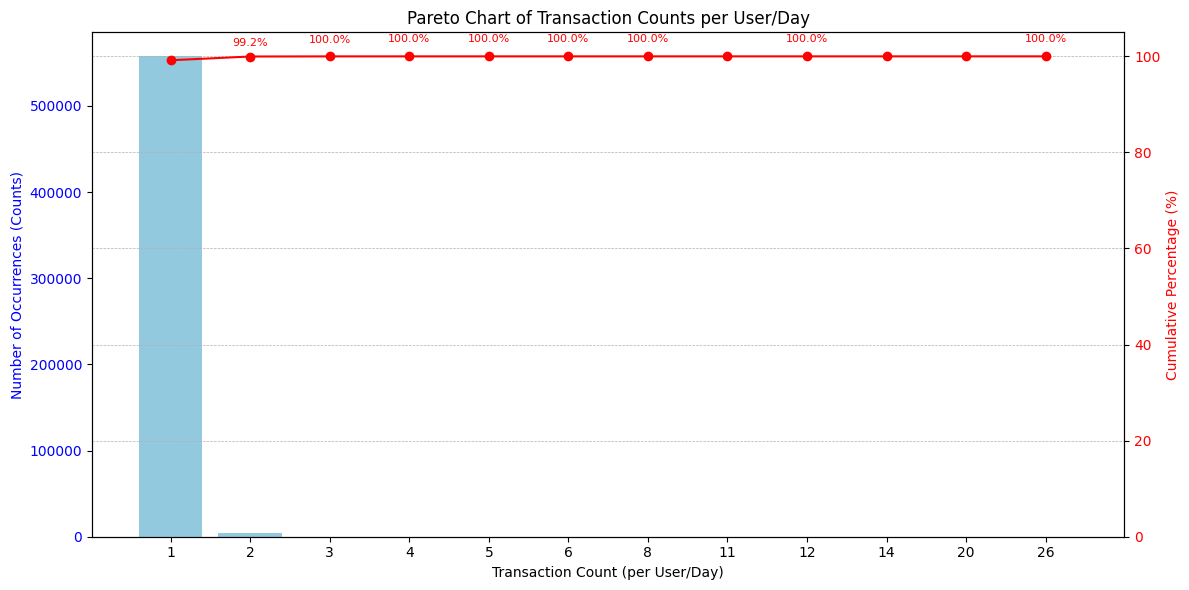

In [36]:
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(x='transaction_count', y='counts', data=daily_user_counts_by_transactions, ax=ax1, color='skyblue')
ax1.set_xlabel('Transaction Count (per User/Day)')
ax1.set_ylabel('Number of Occurrences (Counts)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Pareto Chart of Transaction Counts per User/Day')

ax2 = ax1.twinx()
ax2.plot(daily_user_counts_by_transactions['transaction_count'].astype(str),
         daily_user_counts_by_transactions['proportion'] * 100,
         color='red', marker='o', linestyle='-')
ax2.set_ylabel('Cumulative Percentage (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 105)

for index, row in daily_user_counts_by_transactions.iterrows():
    ax2.annotate(f'{row["proportion"]:.1%}',
                 (row['transaction_count'], row['proportion'] * 100),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')

plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [37]:
outlier_user_list = list(daily_transactions_by_user[daily_transactions_by_user['transaction_count'] > 2]['msno'].unique())
filtering = lambda x: True if x not in outlier_user_list else False
df_transactions['filtered'] = df_transactions['msno'].apply(filtering)

In [38]:
# Check proportion of records of "outlier" users
df_transactions[df_transactions['filtered'] == False].shape[0] / df_transactions.shape[0]

0.004663106433111583

In [39]:
df_transactions = df_transactions[df_transactions['filtered'] == True]
df_transactions = df_transactions.drop(columns=['filtered'])

In [40]:
df_transactions = df_transactions[df_transactions['membership_start_date'] >= '2015-01-01']
df_transactions = df_transactions[df_transactions['membership_expire_date'] <= '2017-03-31']

In [41]:
df_transactions = df_transactions.reset_index(drop=True)

In [42]:
df_transactions.head()

,Unnamed: 0.1,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,membership_start_date
0,2116141,++4qZOZ7rISM4nY9xcUVPweG0A4Z12cGwzjZHmRzr3g=,35,7,0,0,0,2016-11-07,2016-11-14,0,2016-11-07
1,226140,++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,41,30,129,129,1,2015-01-11,2015-05-08,0,2015-04-08
2,15747,++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,41,30,129,129,1,2015-02-11,2015-06-05,0,2015-05-06
3,1522152,++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,41,30,129,129,1,2015-03-11,2015-07-06,0,2015-06-06
4,2380774,++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,41,30,129,129,1,2015-04-11,2015-08-05,0,2015-07-06


In [43]:
# Create silver table and store to Google Cloud Storage
silver_transactions_file_path = "Silver Layer/silver_transactions.csv"
silver_transactions_gcs_path = f"gs://{bucket_name}/{silver_transactions_file_path}"

try:
    df_transactions.to_csv(silver_transactions_gcs_path, index=False)
    print("silver_transactions.csv Stored to Silver Layer Successfully! ✅")
except Exception as e:
    print(f"silver_transactions.csv Store Failed: {e}")

silver_transactions.csv Stored to Silver Layer Successfully! ✅


## EDA

In [26]:
### Ingesting data from Google Cloud Storage
silver_transactions_file_path = "Silver Layer/silver_transactions.csv"
silver_transactions_gcs_path = f"gs://{bucket_name}/{silver_transactions_file_path}"

df_transactions = pd.read_csv(silver_transactions_gcs_path)

In [44]:
result_rows = []

grouped = df_transactions.groupby('msno', sort=False)
for msno, group in tqdm(grouped, total=len(grouped)):
    group = group.reset_index(drop=True)

    for i in range(len(group)):
        row = group.iloc[i]

        start_date = row['membership_start_date']
        expire_date = row['membership_expire_date']
        payment_plan_days = row['payment_plan_days']

        if 30 <= payment_plan_days <= 31 and row['is_cancel'] == 0:

            next_transaction_date = None
            days_diff = None
            for j in range(i + 1, len(group)):
                next_row = group.iloc[j]
                if next_row['is_cancel'] == 0:
                    next_transaction_date = next_row['transaction_date']
                    days_diff = (next_transaction_date - expire_date).days
                    break

            result_rows.append({
                'msno': row['msno'],
                'membership_start_date': start_date,
                'membership_expire_date': expire_date,
                'next_transaction_date': next_transaction_date,
                'days_diff': days_diff,
            })

df_result = pd.DataFrame(result_rows)

100%|██████████| 31194/31194 [01:59<00:00, 261.28it/s]


In [45]:
df_result.loc[df_result['days_diff'] < 0, 'days_diff'] = 0

In [46]:
df_result[df_result['days_diff'] <= 5].sample(5)

,msno,membership_start_date,membership_expire_date,next_transaction_date,days_diff
230091,T5QJLUWzPVF6EIX3f4E1wYN+lIkpXVxaAQ3loHlTBQM=,2015-05-14,2015-06-14,2015-06-15,1.0
153603,IoVH9hiUJ3TFJ/KLiNPFyyENXbYwFkremmPVQIYBQjU=,2015-11-18,2015-12-18,2015-12-17,0.0
100312,BW9qXJLirUKUnnt0ZIQSv2tfgLsAyyuBGxyaS1Lq+dU=,2016-04-17,2016-05-17,2016-05-17,0.0
297883,cEOJPfY4Dr89dIorDvN2q2t1nWWThNcgka0SAaQLatY=,2016-10-18,2016-11-17,2016-11-17,0.0
75287,8AStPxVBnnXcghOYikybYwn974e3fn2QRFLEp5L/Pqo=,2016-10-31,2016-11-30,2016-11-30,0.0


In [47]:
df_result[df_result['days_diff'] > 5].sample(5)

,msno,membership_start_date,membership_expire_date,next_transaction_date,days_diff
387069,oKk5i+A98suZhhHJ/JYxnLearkUBr0g4PgTr16RPyUA=,2016-01-30,2016-02-29,2016-05-20,81.0
309192,dj9cHnDOW7u06NHkjUQu+9qr6xrxWnWxQ6ALATZCjpA=,2015-12-16,2016-01-15,2016-01-31,16.0
169466,KsrdEP7YNfBiBcPY9QSVXec0DiB4KMpGxE14gdPLnIk=,2016-09-04,2016-10-04,2016-10-14,10.0
116866,Dm+XNWFxdJ6VAbUiW0xT7xdxSWCqbA8w3wrCBXjfb94=,2016-07-15,2016-08-14,2016-09-04,21.0
260611,XDd7QyFACg4LNxYGGAmvPY5UdDoDGYeCbKRF2/JfiLQ=,2015-12-11,2016-01-10,2016-01-31,21.0


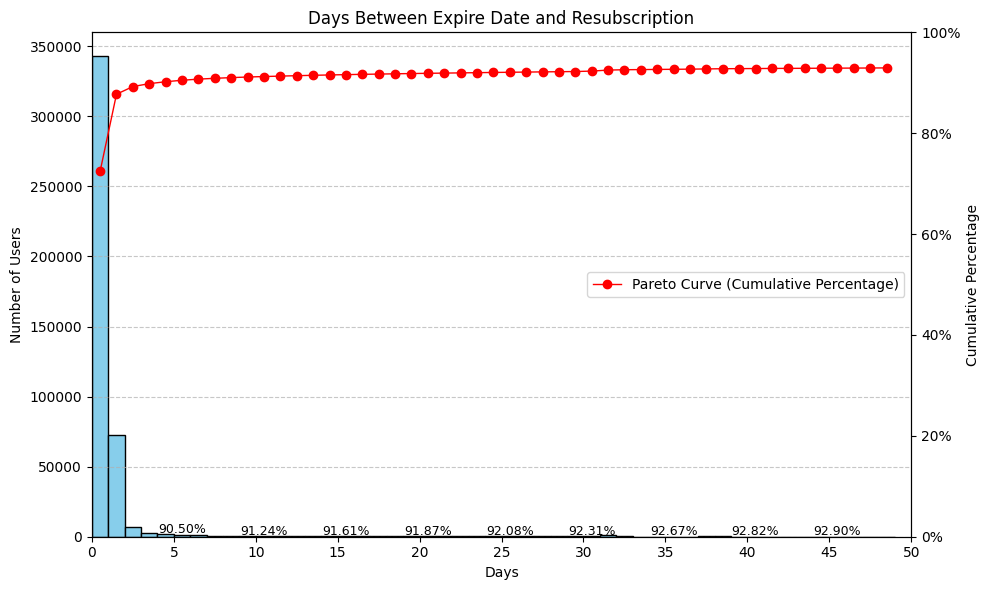

In [48]:
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_result['days_diff'], bins=range(0, 50), color='skyblue', edgecolor='black')

plt.xlim(0, 50)
plt.xticks(range(0, 51, 5))
plt.title('Days Between Expire Date and Resubscription')
plt.xlabel('Days')
plt.ylabel('Number of Users')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

total_count = len(df_result)
x_ticks_to_label = [5, 10, 15, 20, 25, 30, 35, 40, 45]

for x in x_ticks_to_label:
    if x >= len(bins):
        continue

    count_less_than_x = df_result[df_result['days_diff'] <= x].shape[0]
    proportion = count_less_than_x / total_count

    bin_index = x
    patch = patches[bin_index]

    height = patch.get_height()
    bin_center = 0.5 * (bins[bin_index] + bins[bin_index + 1])

    plt.text(
        bin_center,
        height + 1000,
        f'{proportion:.2%}',
        ha='center',
        fontsize=9,
        rotation=0
    )

ax2 = plt.twinx()
cumulative_n = n.cumsum()
cumulative_percentage = cumulative_n / total_count
bin_centers = (bins[:-1] + bins[1:]) / 2
ax2.plot(bin_centers, cumulative_percentage, color='red', marker='o', linestyle='-', linewidth=1, label='Pareto Curve (Cumulative Percentage)')
ax2.set_ylim(0, 1)
ax2.set_ylabel('Cumulative Percentage')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
lines, labels = ax2.get_legend_handles_labels()
plt.legend(lines, labels, loc='center right')

plt.tight_layout()
plt.show()

In [49]:
# Check for small gaps between "membership_expire_date" and "2017-03-31", and if "next_transaction_date" is None,
# drop these rows because it's still unknown whether there will be a next transaction after this or not.
mask_drop = (
    df_result['next_transaction_date'].isna() &
    (pd.to_datetime('2017-03-31') - df_result['membership_expire_date']).dt.days.between(0, 5)
)
df_result = df_result[~mask_drop]

## Gold Layer

In [50]:
grace_period = 5
df_result['churn'] = ((df_result['days_diff'] > grace_period) | (df_result['days_diff'] == "None")).astype(int)

In [51]:
df_labels = df_result[['msno', 'membership_start_date', 'membership_expire_date', 'churn']]

In [52]:
churn_0_sample = df_labels[df_labels['churn'] == 0].sample(3)
churn_1_sample = df_labels[df_labels['churn'] == 1].sample(2)
sampled_df = pd.concat([churn_0_sample, churn_1_sample])
sampled_df

,msno,membership_start_date,membership_expire_date,churn
68460,7JopCbzqZSZGKf11aNfWrqFdTKKCA3idT7PkTyKFeG0=,2016-01-02,2016-02-01,0
470247,zZMMObPmmgU/x96e9V3XUwno2MLDZ+PoX/1C9SQ24HY=,2015-12-05,2016-01-04,0
56116,5eGi5miClZ8WLCsORxYCtYks36BqMMXhEyNHOfBYTug=,2016-10-01,2016-10-31,0
363380,l4Miv2QFJY8n4KSEd64dgveQJoV+s2/vNB6JwENx2Fc=,2016-02-03,2016-03-04,1
367485,lfNkr9VQ5GRRZZnqTLrODC37kp2TcYyvUCqVw9Jft7c=,2015-01-10,2015-02-10,1


Proportion of 0s: 0.958
Proportion of 1s: 0.042


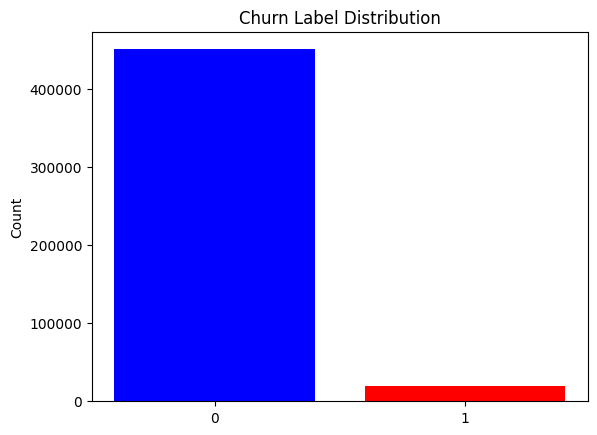

In [53]:
churn_counts = df_labels['churn'].value_counts().sort_index()
churn_proportions = df_labels['churn'].value_counts(normalize=True).sort_index()

print(f"Proportion of 0s: {churn_proportions.iloc[0]:.3f}")
print(f"Proportion of 1s: {churn_proportions.iloc[1]:.3f}")

plt.bar(churn_counts.index, churn_counts.values, color=['blue', 'red'])
plt.ylabel('Count')
plt.xticks([0, 1])
plt.title('Churn Label Distribution')
plt.show()

In [54]:
# Create gold table and store to Google Cloud Storage
gold_label_file_path = "Gold Layer/labels.csv"
gold_label_gcs_path = f"gs://{bucket_name}/{gold_label_file_path}"

try:
    df_labels.to_csv(gold_label_gcs_path, index=False)
    print("labels.csv Stored to Gold Layer Successfully! ✅")
except Exception as e:
    print(f"labels.csv Store Failed: {e}")

labels.csv Stored to Gold Layer Successfully! ✅
